# Fundus Image-Based Diagnosis of Multiple Ocular Diseases Using Deep Convolutional Neural Networks

This notebook demonstrates the entire end-to-end process of developing our deep learning model.

Authored by: Derek Huynh, Matthew Biniam

## Table of Contents
[0 &ensp; Imports](#0--Imports)\
[1 &ensp; Data Cleaning and Analysis](#1-Data-Cleaning-and-Analysis)\
&ensp; &ensp; &ensp; &ensp;[1.1 &nbsp; G1020 (Glaucoma)](#1.1-G1020-(Glaucoma))\
&ensp; &ensp; &ensp; &ensp;[1.2 &nbsp; IDRiD (Indian Diabetic Retinopathy Image Dataset)](#1.2-IDRiD-(Indian-Diabetic-Retinopathy-Image-Dataset))\
&ensp; &ensp; &ensp; &ensp;[1.3 &nbsp; ODIR-5K (Multiple)](#1.3-ODIR-5K-(Multiple))

### 0  Imports

Here we import multiple third-party and built-in libraries for extended functionality within the scope of this
project. All our models were built using the TensorFlow framework as well as its high-level API Keras. Various
data analysis and scientific computing libraries are also used including NumPy and Pandas. Seaborn and Matplotlib
are used for data visualization.

In [1]:
import os
import random
import sys

import tensorflow as tf
import tqdm
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})

# Color mappings for plota
viridis = plt.get_cmap('viridis')

# Min-max scale values to pass to cmap function
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

# Setting keras backend alias
K = keras.backend

### 1 Data Cleaning and Analysis

The data that we have collected is sourced from 11 different public datasets containing a total of 18,236 retinal
fundus images. It is necessary to perform cursory data analysis on these in order to identify outliers and
determine a strategy to unify the features and labels to maximize the amount of usable data.

**Predicted issues that will have to be addressed:**
* Features and annotations are not likely to be shared along datasets, meaning it may be necesary to exclude those
  that may pose an issue when implementing them into the data pipeline of our model
* Different image sizes, formats, quality etc.

### 1.1 G1020 (Glaucoma)

G1020 is a very recently released glaucoma dataset, published on May 28th, 2020. It contains a total of 1020
retinal fundus images derived from 432 patients. 296 images are marked glaucoma positive and 724 are marked
healthy.

In [795]:
# Paths to dataset
G1020_IMAGES = os.path.join(os.curdir, '../data/G1020/images/')
G1020_LABELS = os.path.join(os.curdir, '../data/G1020/G1020.csv')

# Using Pandas to read from the annotations
labels = pd.read_csv(G1020_LABELS)
print(labels.columns)
labels.tail(10)

Index(['Unnamed: 0', 'patientID', 'imageName', 'imageID', 'Left/Right',
       'detailedLabels', 'binaryLabels', 'diagnosis', 'gLabels'],
      dtype='object')


,Unnamed: 0,patientID,imageName,imageID,Left/Right,detailedLabels,binaryLabels,diagnosis,gLabels
1010,1010,zjzxx743ys8l297,ac8632d9-76e7-481c-a040-6db81013ce10.jpg,image_3170.jpg,Right,0a,0,"Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...",NaN
1011,1011,zovo0er47tk3z7v,15c27078-6677-4b82-b56f-37f785ce464b.jpg,image_3182.jpg,Right,1a,1,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...",NaN
1012,1012,zovo0er47tk3z7v,5314cd79-52fa-4360-a5ea-50754ff3776a.jpg,image_3183.jpg,Right,1a,1,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...",NaN
1013,1013,zovo0er47tk3z7v,e0cf5297-461a-488b-ae40-b98df7f8e423.jpg,image_3184.jpg,Left,1a,1,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...",NaN
1014,1014,zovo0er47tk3z7v,fa127b77-12cc-47d5-8d7b-30b6425969fb.jpg,image_3185.jpg,Left,1a,1,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...",NaN
1015,1015,zv6f84bnud789vg,1b93736f-a295-4abc-acdf-5ae15d115bff.jpg,image_3198.jpg,Left,0a,0,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G] |...",NaN
1016,1016,zv6f84bnud789vg,f44193e6-2d1f-4824-b405-e32f8e4160df.jpg,image_3199.jpg,Left,0a,0,"Hyperopie [H52.0 G], Astigmatismus [H52.2 G] |...",NaN
1017,1017,zzyw7okz2b8xvnl,549f9f45-fe3b-4838-8452-cbc957813652.jpg,image_3201.jpg,Left,1a,1,"Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...",NaN
1018,1018,zzyw7okz2b8xvnl,d40d9881-d073-4539-85dc-e0109ae74a6e.jpg,image_3202.jpg,Left,1a,1,"Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...",NaN
1019,1019,solihwy757bc165,0bd853d4-ced4-4667-9bf5-a4237bc904a8.jpg,image_2568.jpg,Right,0a,0,"Myopie [H52.1 GR], Presbyopie [H52.4 G], |BA, ...",NaN


Text(0.5, 1.0, 'G1020 Distribution')

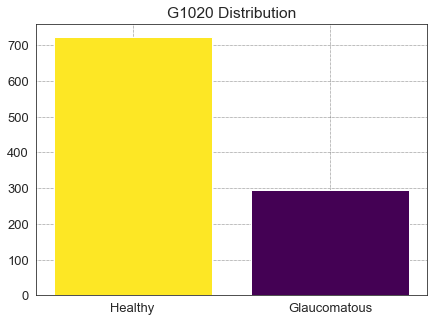

In [797]:
# Distribution of G1020
x = ['Healthy', 'Glaucomatous']
y = labels['binaryLabels'].value_counts()

plt.bar(x, y, color=viridis(rescale(y)))
plt.title('G1020 Distribution')

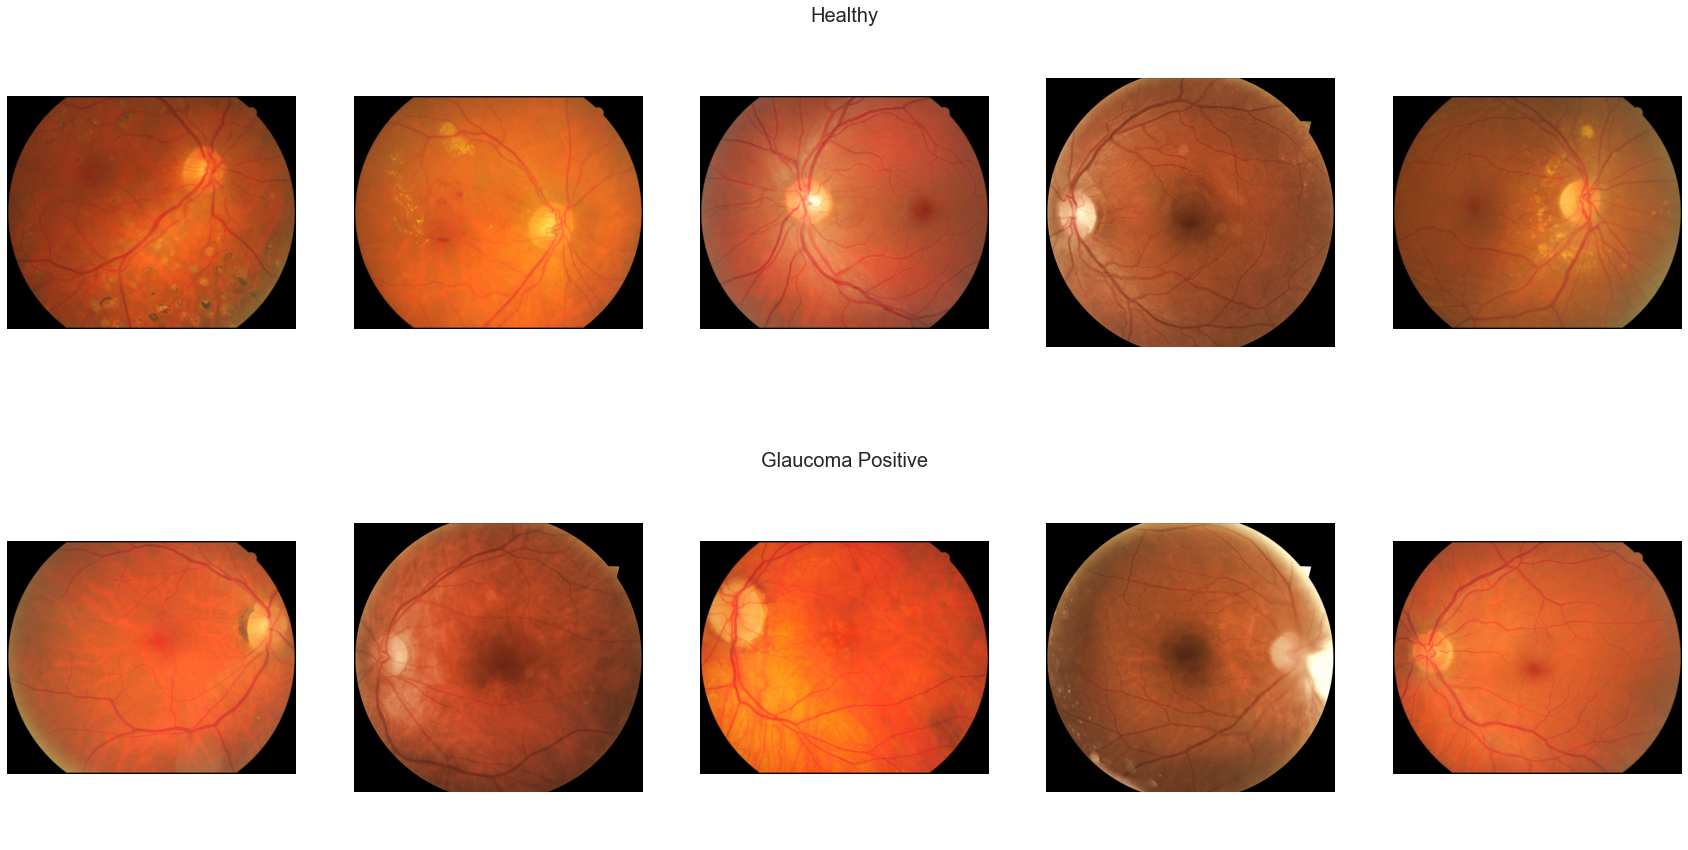

In [92]:
# Get examples of healthy and glaucomous
healthy = labels['imageID'][labels['binaryLabels'] == 0][:5].tolist()
glaucoma = labels['imageID'][labels['binaryLabels'] == 1][:5].tolist()
examples = healthy + glaucoma

fig, axes = plt.subplots(2, 1, figsize=(30, 15), sharey=True)

for ind, row in enumerate(axes):
    if ind == 0:
        row.set_title('Healthy', fontsize=20)
    else:
        row.set_title('Glaucoma Positive', fontsize=20)
    # Removes axes and ticks
    row.axis('off')
    rwo.grid['off']
    # removes the white frame
    row._frameon = False
    
for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i)
    ax.axis('off')
    img_path = os.path.join(G1020_IMAGES, examples[i-1])
    img = PIL.Image.open(img_path)
    ax.imshow(img)

### 1.2 IDRiD (Indian Diabetic Retinopathy Image Dataset)

In [9]:
# Split into train and test images as well as labels
IDRID_IMAGES = os.path.join(os.curdir, '../data/idrid/train/')
IDRID_LABELS = os.path.join(os.curdir, '../data/idrid/train.csv')
IDRID_TEST = os.path.join(os.curdir, '../data/idrid/test.csv')

# Using Pandas to read from the annotations
labels = pd.read_csv(IDRID_LABELS)
print(labels.columns)
labels.tail(10)

Index(['Image name', 'Retinopathy grade', 'Risk of macular edema ',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')


,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
403,IDRiD_404,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,IDRiD_405,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
405,IDRiD_406,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,IDRiD_407,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,IDRiD_408,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,IDRiD_409,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,IDRiD_410,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,IDRiD_411,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,IDRiD_412,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,IDRiD_413,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The unnamed columns don't matter. From their 2018 paper, Diabetic Retinopathy (DR) grades range from 0(no DR) to 4
(severe DR) and Diabetic Macular Edema (DME) range from 0(no DME) to 2 (severe DME).

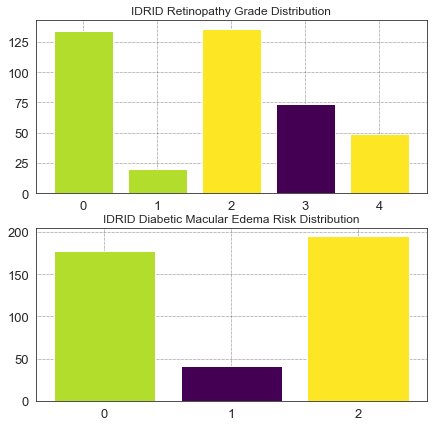

In [10]:
# Getting counts of each rating
# Proportions seem to slightly favour unhealthy examples
mpl.rcParams['axes.grid'] = True
fig, axes = plt.subplots(2, 1, figsize=(7, 7))

dr = labels['Retinopathy grade']
dme = labels.iloc[:, 2]
dr_counts = labels['Retinopathy grade'].value_counts()
dme_counts = labels.iloc[:, 2].value_counts()

axes[0].set_title('IDRID Retinopathy Grade Distribution', fontsize=12)
axes[1].set_title('IDRID Diabetic Macular Edema Risk Distribution', fontsize=12)

axes[0].bar(dr_counts.index, dr_counts, color=viridis(rescale(dme_counts)))
axes[1].bar(dme_counts.index, dme_counts, color=viridis(rescale(dme_counts)))
ticks = axes[1].set_xticks(range(3))

A likely approach we will take would be to rename the columns of each relevant disease to make it easier to
combine the datasets. In the case where there aren't grades of things like DR in other datasets, we may have to 
modify the labels to make them binary.

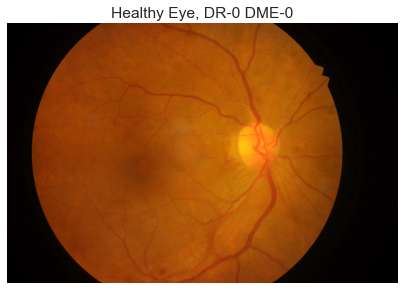

In [187]:
healthy = labels['Image name'][(dr == 0) & (dme == 0)].tolist()[0]
dr_img = [labels['Image name'][(dr == i) & (dme == 0)].tolist()[0] for i in range(1, 5)]

# Something very interesting, there are no images with a DME rating that don't have
# a DR rating, that's why here we don't try to keep the DR grade at 0
dme_img = [labels['Image name'][dme == i].tolist()[0] for i in range(1, 3)]
examples = dr_img + dme_img

healthy_img = PIL.Image.open(IDRID_IMAGES + healthy + '.jpg')
plt.title('Healthy Eye, DR-0 DME-0')
plt.axis('off')
plt.imshow(healthy_img)

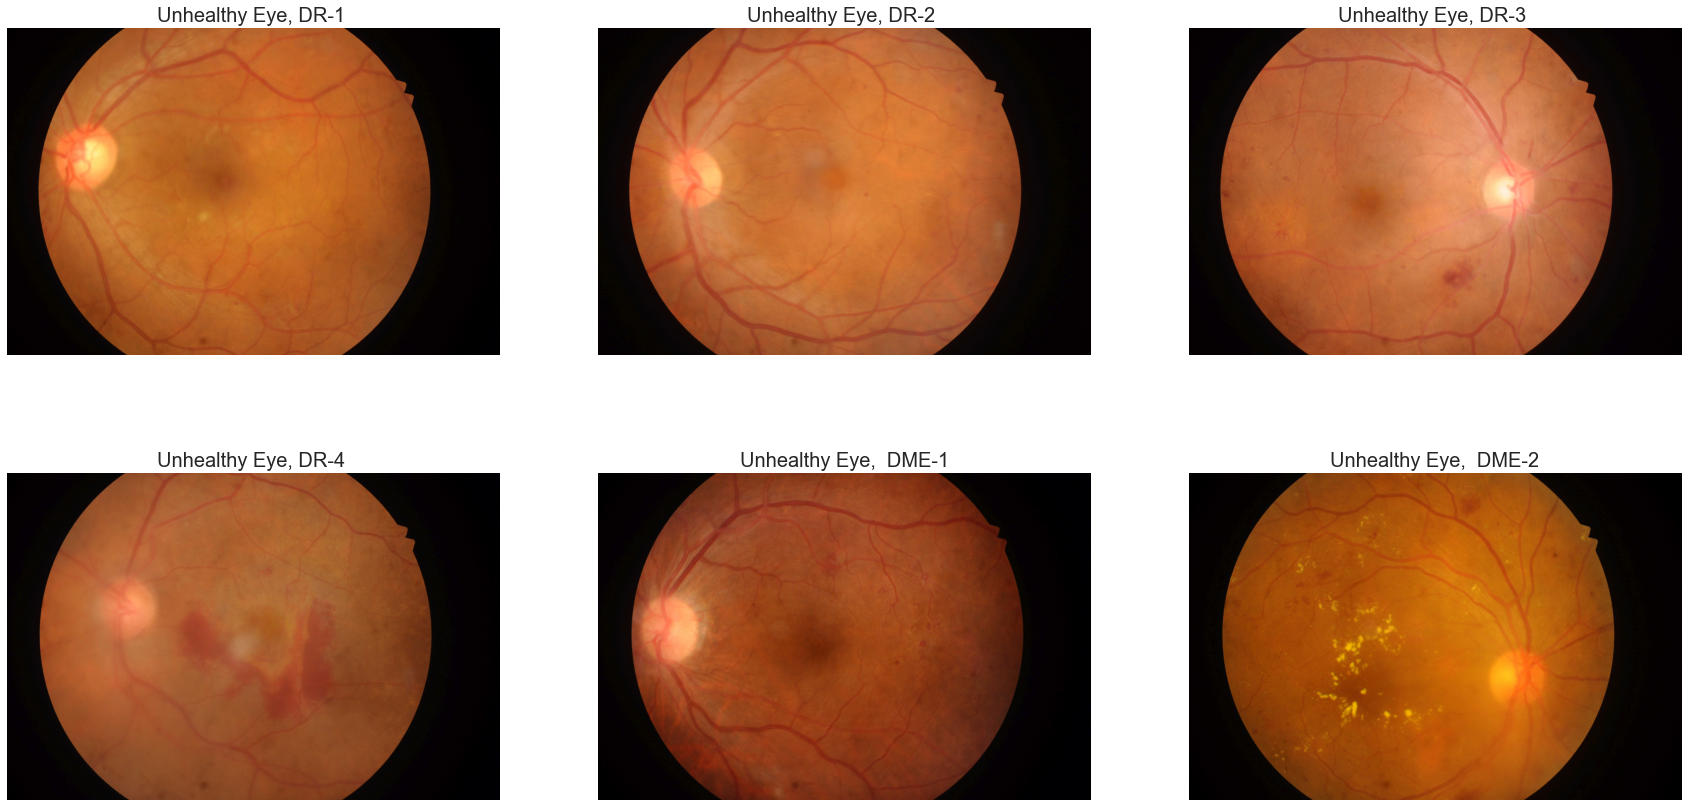

In [186]:
fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharey=True)

ind = 0
dr_val = 0
dme_val = 0
for row in axes:
    for ax in row:
        ax.axis('off')
        ax.grid('off')
        if ind+1 > 4:
            dr_val = ''
            dme_val = f'DME-{ind+1 - 4}'
        else:
            dme_val = ''
            dr_val = f'DR-{ind+1}'
        ax.set_title(f'Unhealthy Eye, {dr_val} {dme_val}', fontsize=20)
        img_path = os.path.join(IDRID_IMAGES, examples[ind]+'.jpg')
        img = PIL.Image.open(img_path)
        ax.imshow(img)
        ind += 1

### 1.3 REFUGE (Glaucoma)

In [921]:
REFUGE_IMAGES = os.path.join(os.curdir, '../data/refuge/train/')
REFUGE_LABELS = os.path.join(os.curdir, '../data/refuge/train.xlsx')
REFUGE_VALID = os.path.join(os.curdir, '../data/refuge/validation.xlsx')

# Need to add a column of glaucoma labels, they are given in the file name
# and are separated in the folders themselves
labels = pd.read_excel(REFUGE_LABELS)
labels

,ID,ImgName,Fovea_X,Fovea_Y
0,1,g0001.jpg,1057.95,1076.52
1,2,g0002.jpg,1190.59,1017.09
2,3,g0003.jpg,1070.56,1084.85
3,4,g0004.jpg,1072.60,1035.48
4,5,g0005.jpg,1058.19,1100.33
...,...,...,...,...
395,396,n0356.jpg,1229.73,1043.89
396,397,n0357.jpg,1080.45,1081.30
397,398,n0358.jpg,1288.78,1122.37
398,399,n0359.jpg,1239.17,1077.17


In [922]:
corrected_names = 'REFUGE' + labels[40:].loc[:, 'ImgName']
labels.iloc[40:, 1] = corrected_names
labels

,ID,ImgName,Fovea_X,Fovea_Y
0,1,g0001.jpg,1057.95,1076.52
1,2,g0002.jpg,1190.59,1017.09
2,3,g0003.jpg,1070.56,1084.85
3,4,g0004.jpg,1072.60,1035.48
4,5,g0005.jpg,1058.19,1100.33
...,...,...,...,...
395,396,REFUGEn0356.jpg,1229.73,1043.89
396,397,REFUGEn0357.jpg,1080.45,1081.30
397,398,REFUGEn0358.jpg,1288.78,1122.37
398,399,REFUGEn0359.jpg,1239.17,1077.17


In [923]:
# Categorizing the images by their file names, those with glaucoma start with
# a 'g' and those without start with an 'n'
category = [0] * 400
image_names = labels['ImgName'].tolist()
for ind, val in enumerate(image_names):
    if val[0] is 'g':
        category[ind] = 1
    else:
        category[ind] = 0
labels['glaucoma'] = category
labels.head()
labels.to_csv('../data/refuge/train.csv', index=False)

In [924]:
REFUGE_LABELS = os.path.join(os.curdir, '../data/refuge/train.csv')
labels = pd.read_csv(REFUGE_LABELS)
labels.tail(10)

,ID,ImgName,Fovea_X,Fovea_Y,glaucoma
390,391,REFUGEn0351.jpg,1061.35,1017.61,0
391,392,REFUGEn0352.jpg,1170.87,1056.15,0
392,393,REFUGEn0353.jpg,1301.83,1037.36,0
393,394,REFUGEn0354.jpg,1149.57,1082.00,0
394,395,REFUGEn0355.jpg,1205.72,1078.18,0
395,396,REFUGEn0356.jpg,1229.73,1043.89,0
396,397,REFUGEn0357.jpg,1080.45,1081.30,0
397,398,REFUGEn0358.jpg,1288.78,1122.37,0
398,399,REFUGEn0359.jpg,1239.17,1077.17,0
399,400,REFUGEn0360.jpg,1237.73,1089.06,0


Text(0.5, 1.0, 'REFUGE Distribution')

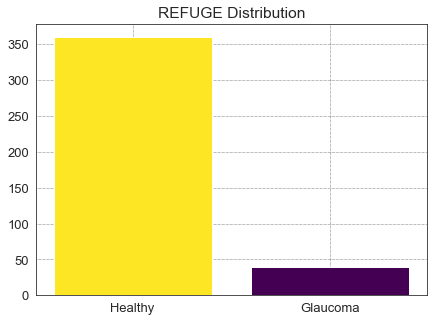

In [598]:
x = ['Healthy', 'Glaucoma'] 
y = labels['glaucoma'].value_counts()
plt.bar(x, y, color=viridis(rescale(y)))
plt.title('REFUGE Distribution')

### 1.4 ADAM (Age-related Macular Degeneration)

In [2]:
# No labels are provided for this dataset
# but they are divided into their respected subdirectories
ADAM_IMAGES = os.path.join(os.curdir, '../data/amd/train/')
ADAM_LABELS = os.path.join(os.curdir, '../data/amd/adam_train.csv')

frame = {'image_names': [], 'AMD': []}
for file in os.listdir(ADAM_IMAGES):
    frame['image_names'].append(file)
    if file[0] == 'A':
        frame['AMD'].append(1)
    else:
        frame['AMD'].append(0)
labels = pd.DataFrame(frame)
labels.to_csv(ADAM_LABELS, index=False)
labels.tail()

,image_names,AMD
396,N0223.jpg,0
397,N0237.jpg,0
398,N0021.jpg,0
399,N0035.jpg,0
400,N0009.jpg,0


Text(0.5, 1.0, 'ADAM Distribution')

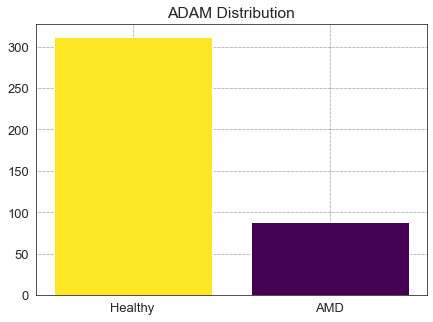

In [8]:
x = ['Healthy', 'AMD']
y = labels['AMD'].value_counts()
plt.bar(x, y, color=viridis(rescale(y)))
plt.title('ADAM Distribution')

### 1.5 Messidor-2

Labels provided by Google Brain.

In [973]:
# Contains both png and jpg files
MESSIDOR_IMAGES = os.path.join(os.curdir, '../data/messidor/train/')
MESSIDOR_LABELS = os.path.join(os.curdir, '../data/messidor/messidor_data.csv')
labels = pd.read_csv(MESSIDOR_LABELS)

# Need to correct the names of .jpg files
messidor_im = labels.iloc[labels.shape[0]-690:]['image_id'].tolist()
for i, name in enumerate(messidor_im):
    name = name.replace('jpg', 'JPG')
    messidor_im[i] = name
labels.iloc[labels.shape[0]-690:, 0] = messidor_im
MESSIDOR_LABELS = os.path.join(os.curdir, '../data/messidor/messidor_data_corrected.csv')
labels.to_csv(MESSIDOR_LABELS)
labels.tail(10)

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
1738,IM004782.JPG,0.0,0.0,1
1739,IM004783.JPG,0.0,0.0,1
1740,IM004797.JPG,1.0,0.0,1
1741,IM004798.JPG,0.0,0.0,1
1742,IM004805.JPG,0.0,0.0,1
1743,IM004806.JPG,0.0,0.0,1
1744,IM004811.JPG,1.0,0.0,1
1745,IM004812.JPG,2.0,0.0,1
1746,IM004831.JPG,0.0,0.0,1
1747,IM004832.JPG,0.0,0.0,1


<BarContainer object of 2 artists>

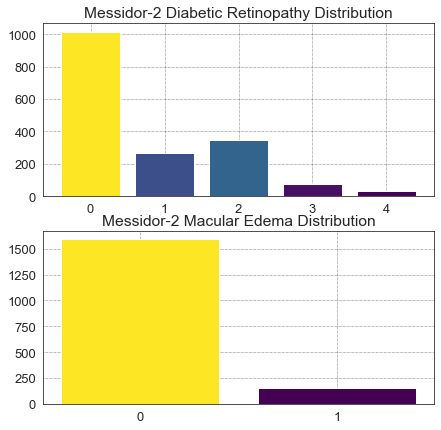

In [561]:
# Diabetic retinopathy grades from 0 to 4
dr = labels.iloc[:, 1]
dr_count = dr.value_counts()

# Macular edema 
me = labels.iloc[:, 2]
me_count = me.value_counts()

fig, axes = plt.subplots(2, 1, figsize=(7,7))

# DR distributions
axes[0].set_xticks(range(5))
axes[0].set_title('Messidor-2 Diabetic Retinopathy Distribution')
axes[0].bar(dr_count.index, dr_count, color=viridis(rescale(dr_count)))

# ME distributions
axes[1].set_xticks(range(2))
axes[1].set_title('Messidor-2 Macular Edema Distribution')
axes[1].set_yticks(range(0, 1501, 250))
axes[1].bar(me_count.index, me_count, color=viridis(rescale(me_count)))

### 1.6 PALM (Myopia)

In [616]:
# No labels provided for data set, category can be determined
# by the image names. P (pathological myopia), H (high myopia)
# and N (normal fundus)
PALM_IMAGES = os.path.join(os.curdir, '../data/palm/images/')
PALM_LABELS = os.path.join(os.curdir, '../data/palm/palm_train.csv')

# Creating labels based on file name
palm_labels = {'image_names': [], 'myopia': []}
for file in os.listdir(PALM_IMAGES):
    palm_labels['image_names'].append(file)
    category = file.strip('palm_')[0]
    if category is 'P' or category is 'H':
        palm_labels['myopia'].append(1)
    else:
        palm_labels['myopia'].append(0)
labels = pd.DataFrame(palm_labels)
labels.to_csv(PALM_LABELS, index=False)
labels.tail(10)

,image_names,myopia
390,palm_P0095.jpg,1
391,palm_P0042.jpg,1
392,palm_P0056.jpg,1
393,palm_N0144.jpg,0
394,palm_N0150.jpg,0
395,palm_N0030.jpg,0
396,palm_N0024.jpg,0
397,palm_N0018.jpg,0
398,palm_P0136.jpg,1
399,palm_P0122.jpg,1


Text(0.5, 1.0, 'PALM Myopia Distribution')

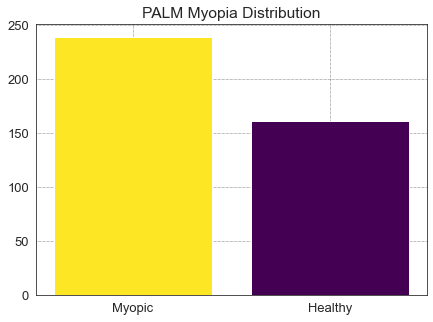

In [572]:
x = ['Myopic', 'Healthy']
y = labels['myopia'].value_counts()
plt.bar(x, y, color=viridis(rescale(y)))
plt.title('PALM Myopia Distribution')

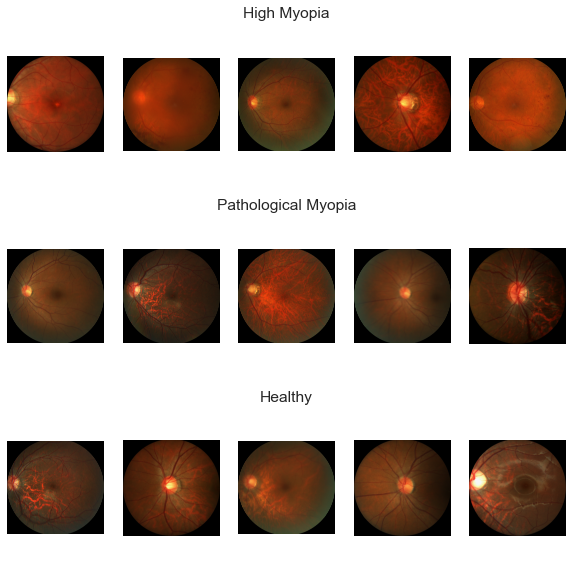

In [594]:
# Getting image examples of high, pathological myopia and normal images
myopic = labels['image_names'][labels['myopia'] == 1].tolist()
healthy = labels['image_names'][labels['myopia'] == 0].iloc[:5].tolist()

high_myopia = []
pathological_myopia = []

for img_name in myopic:
    if img_name[5] is 'P':
        pathological_myopia.append(img_name)
    else:
        high_myopia.append(img_name)
        
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=True)
titles = ['High Myopia', 'Pathological Myopia', 'Healthy']
for ind, row in enumerate(axes):
    row.set_title(titles[ind])
    
    # Removes axes and ticks
    row.axis('off')
    row.grid('off')
    
    # removes the white frame
    row._frameon = False

# Add sub-subplots
for i in range(1, 16):
    ax = fig.add_subplot(3, 5, i)
    ax.axis('off')
    ax.grid('off')
    img_path = os.path.join(PALM_IMAGES, palm_images[i-1])
    img = PIL.Image.open(img_path)
    ax.imshow(img)

### 1.7 RFMiD (Multiple)

In [531]:
RFMID_IMAGES = os.path.join(os.curdir, '../data/rfmid/train/')
RFMID_LABELS = os.path.join(os.curdir, '../data/rfmid/train.csv')
labels = pd.read_csv(RFMID_LABELS)

# Adding the .png file extension to the ID
file_names = labels['ID'].astype(str) + '.png'
labels['ID'] = file_names
labels.tail(10)

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
1910,1911.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1911,1912.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1912,1913.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1913,1914.png,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1914,1915.png,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1915,1916.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1919,1920.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [515]:
labels.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'],
      dtype='object')

> "*This dataset consists of diseases/abnormalities (diabetic retinopathy (DR), age-related macular degeneration*
*(ARMD), media haze (MZ), drusen (DN), myopia (MYA), branch retinal vein occlusion (BRVO), tessellation (TSLN),*
*epiretinal membrane (ERM), laser scar (LS), macular scar (MS), central serous retinopathy (CSR), optic disc*
*cupping (ODC), central retinal vein occlusion (CRVO), tortuous vessels (TV), asteroid hyalosis (AH), optic disc*
*pallor (ODP), optic disc edema (ODE), shunt (ST), anterior ischemic optic neuropathy (AION), parafoveal*
*telangiectasia (PT), retinal traction (RT), retinitis (RS), chorioretinitis (CRS), exudation (EDN), retinal*
*pigment epithelium changes (RPEC), macular hole (MHL), retinitis pigmentosa (RP), cotton wool spots (CWS),*
*coloboma (CB), optic disc pit maculopathy (ODPM), preretinal hemorrhage (PRH), myelinated nerve fibers (MNF),*
*hemorrhagic retinopathy (HR), central retinal artery occlusion (CRAO), tilted disc (TD), cystoid macular edema* 
*(CME), post traumatic choroidal rupture (PTCR), choroidal folds (CF), vitreous hemorrhage (VH), macroaneurysm*
*(MCA), vasculitis (VS), branch retinal artery occlusion (BRAO), plaque (PLQ), hemorrhagic pigment epithelial*
*detachment (HPED) and collateral (CL))*" [Source](https://riadd.grand-challenge.org/Data/)

<BarContainer object of 28 artists>

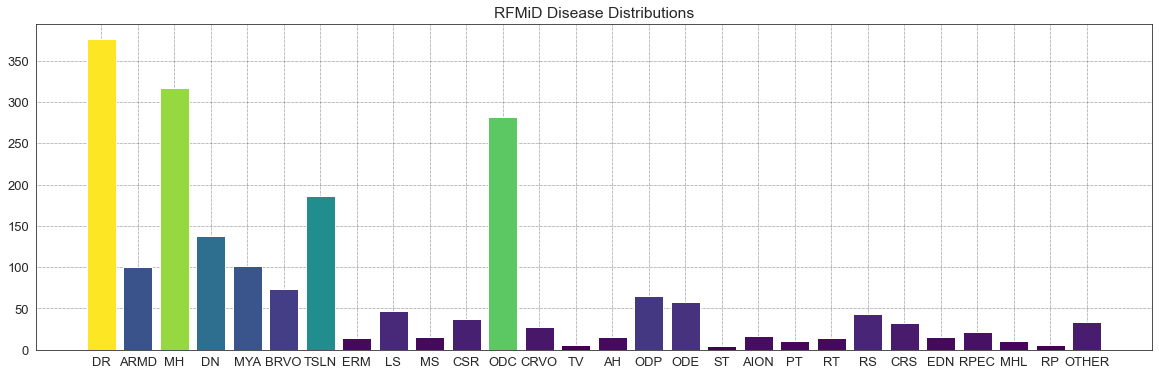

In [551]:
# Plotting the distributions of the diseases in th data set
distributions = labels.iloc[:, 2:].sum()
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('RFMiD Disease Distributions')
ax.bar(distributions.index, distributions, color=dist_cmap(rescale(distributions)))

Text(0.5, 1.0, 'Healthy vs. Unhealthy RFMiD')

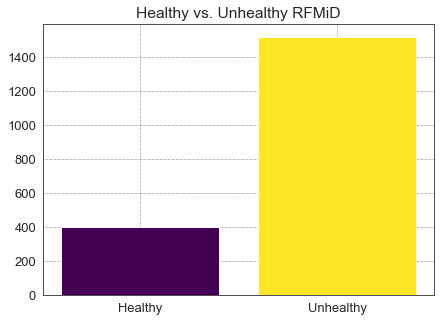

In [507]:
# Healthy vs. Unhealthy labels
healthy = labels[labels['Disease_Risk'] == 0]['Disease_Risk'].shape[0]
unhealthy = labels['Disease_Risk'].sum()
x = ['Healthy', 'Unhealthy']
y = [healthy, unhealthy]
plt.bar(x, y, color=dist_cmap(rescale(y)))
plt.title('Healthy vs. Unhealthy RFMiD' )

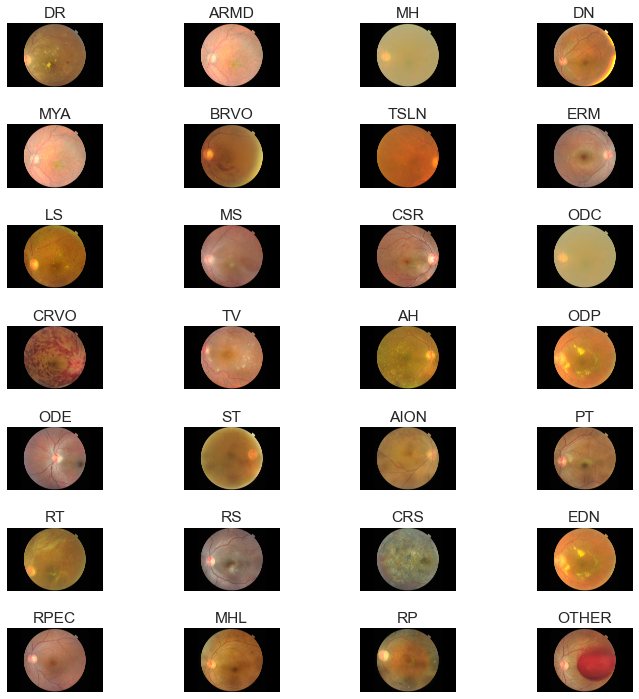

In [550]:
# Examples of each disease
fig, axes = plt.subplots(7, 4, figsize=(10, 10))

# Keep a uniform layout and to prevent title spillover
fig.tight_layout()

diseases = labels.columns[2:]
rind = 0
cind = 0
for ind, col in enumerate(diseases):
    img_name = labels['ID'][labels[col] == 1].iloc[0]
    img = PIL.Image.open(RFMID_IMAGES + img_name)
    ax = axes[rind][cind]
    ax.grid('off')
    ax.axis('off')
    ax.set_title(col)
    ax.imshow(img)
    cind += 1
    if cind > len(axes[0]) - 1:
        cind = 0
        rind += 1

### 1.8 ODIR-5K (Multiple)

This dataset has diverse category labels and a large number of images.

In [708]:
ODIR_IMAGES = os.path.join(os.curdir, '../data/odir/train/')
ODIR_LABELS = os.path.join(os.curdir, '../data/odir/train.xlsx')

labels = pd.read_excel(ODIR_LABELS)
labels.tail(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
3490,4677,38,Male,4677_left.jpg,4677_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3491,4678,54,Male,4678_left.jpg,4678_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3492,4679,69,Male,4679_left.jpg,4679_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3493,4682,45,Male,4682_left.jpg,4682_right.jpg,mild nonproliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3494,4683,58,Male,4683_left.jpg,4683_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3499,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0


In [468]:
# The labels are per patient, however I can use the diagnostic keywords
# to create labels for each individual eye
left_keywords = labels.iloc[:, 5].unique()
right_keywords = labels.iloc[:, 6].unique()
keywords = np.concatenate([left_keywords, right_keywords])

def split_diagnoses(diagnosis):
    """
    Split up the diagnosis strings into a list. Annoyingly there are
    two different types of commas delineating the diagnostic labels
    
    Parameters
    ----------
    diagnosis: set
         Contains all the diagnostic labels in the dataset.
         
    Returns
    -------
    words: list
        The split diagnostic labels.
    """
    if '，' in diagnosis:
        words = diagnosis.split('，')
    else:
        words = diagnosis.split(',')
    return words 

def get_diagnoses(diagnoses):
    d = set()
    for diagnosis in diagnoses:
        # There are annoyingly two different commas separating the diagnoses
        words = split_diagnoses(diagnosis)
        for j in words:
            d.add(j)
    return d

diagnoses = get_diagnoses(keywords)
diagnoses, len(diagnoses)

({'abnormal pigment ',
  'age-related macular degeneration',
  'anterior segment image',
  'arteriosclerosis',
  'asteroid hyalosis',
  'atrophic change',
  'atrophy',
  'branch retinal artery occlusion',
  'branch retinal vein occlusion',
  'cataract',
  'central retinal artery occlusion',
  'central retinal vein occlusion',
  'central serous chorioretinopathy',
  'chorioretinal atrophy',
  'chorioretinal atrophy with pigmentation proliferation',
  'choroidal nevus',
  'congenital choroidal coloboma',
  'depigmentation of the retinal pigment epithelium',
  'diabetic retinopathy',
  'diffuse chorioretinal atrophy',
  'diffuse retinal atrophy',
  'drusen',
  'dry age-related macular degeneration',
  'epiretinal membrane',
  'epiretinal membrane over the macula',
  'fundus laser photocoagulation spots',
  'glaucoma',
  'glial remnants anterior to the optic disc',
  'hypertensive retinopathy',
  'idiopathic choroidal neovascularization',
  'image offset',
  'intraretinal hemorrhage',
  'i

In [470]:
# Search for a given substring within diagnoses in the set
def get_kw(keyword, diagnoses_set):
    keyword_set = set()
    for kw in diagnoses_set:
        if keyword in kw:
            keyword_set.add(kw)
    return keyword_set

def create_kw(diagnoses_set):
    # Generate mappings for each disease
    normal_kw = set(['normal fundus'])
    non_indicator_kw = set(['lens dust', 'optic disk photographically invisible', 'anterior segment image', 'no fundus image', 'image offset', 'low image quality'])
    retinopathy_kw = get_kw('retinopathy', diagnoses_set)
    glaucoma_kw = get_kw('glaucoma', diagnoses_set)
    cataract_kw = get_kw('cataract', diagnoses_set)
    amd_kw = get_kw('age-related', diagnoses_set)
    hypertension_kw = get_kw('hypertens', diagnoses_set)
    myopia_kw = get_kw('myop', diagnoses_set)

    # Removing instances that belong to another class
    retinopathy_kw = retinopathy_kw.difference(myopia_kw)
    retinopathy_kw.remove('central serous chorioretinopathy')
    retinopathy_kw.remove('old chorioretinopathy')
    retinopathy_kw.remove('hypertensive retinopathy')

    # Determining the diagnoses present in the "other" category
    named_labels = normal_kw.union(retinopathy_kw, myopia_kw, glaucoma_kw, hypertension_kw, amd_kw, cataract_kw)
    other_kw = diagnoses.difference(named_labels.union(non_indicator_kw))
    
    kw = [normal_kw, retinopathy_kw, glaucoma_kw, cataract_kw, amd_kw, hypertension_kw, myopia_kw, other_kw]
    return kw

def match_diagnoses(diagnosis, df):
    """Some testing code to ensure that my algorithm will properly
    label the left and right fundus images using the diagnostic labels"""
    left = df.iloc[:, 5]
    left_index = left.index
    right = df.iloc[:, 6]
    right_index = right.index

    left_valid = set()
    right_valid = set()
    for ind, (left_d, right_d) in enumerate(zip(left.tolist(), right.tolist())):
        for d in diagnosis:
            if d in left_d:
                left_valid.add(left_index[ind])
            if d in right_d:
                 right_valid.add(right_index[ind])
                
    indices = list(left_valid.union(right_valid))
    return df.iloc[indices]

all_kw = create_kw(diagnoses)
cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for kw, label in zip(all_kw, cols):
    test = match_diagnoses(kw, labels)
    print(test[label].sum(), labels[label].sum())

1139 1140
1128 1128
215 215
212 212
164 164
103 103
174 174
979 979


> Note that the normal fundus images don't add up as there is one patient that does not have the keywords
'normal fundus' yet has been labeled as such (has 'low quality image' as a label, which will be removed 
anyways).

In [12]:
def label_odir(keyword_sets, df):
    left = df.iloc[:, 5]
    left_index = left.index
    right = df.iloc[:, 6]
    right_index = right.index
    
    patient_id = []
    img_names = []
    labels = []
    diagnoses = []
    
    for dfind, (left_d, right_d) in enumerate(zip(left.tolist(), right.tolist())):
        l_one_hot = np.zeros(8, dtype=int)
        r_one_hot = np.zeros(8, dtype=int)
        ldiag = split_diagnoses(left_d)
        rdiag = split_diagnoses(right_d)
        for d in ldiag:
            for ind, kwset in enumerate(keyword_sets):
                if d in kwset:
                    l_one_hot[ind] = 1
                    break
        for d in rdiag:
            for ind, kwset in enumerate(keyword_sets):
                if d in kwset:
                    r_one_hot[ind] = 1
                    break
        row = df.iloc[dfind]
        patient_id.extend([row['ID']] * 2)
        img_names.extend([row['Left-Fundus'], row['Right-Fundus']])
        diagnoses.append(','.join(ldiag))
        diagnoses.append(','.join(rdiag))
        labels.append(l_one_hot)
        labels.append(r_one_hot)
        
    columns = ['ID', 'image_name', 'diagnosis', 'N', 'DR', 'G', 'C', 'AMD', 'H', 'M', 'O']
    patient_id = np.asarray(patient_id).reshape(-1, 1)
    img_names = np.asarray(img_names).reshape(-1, 1)
    diagnoses = np.asarray(diagnoses).reshape(-1, 1)
    labels = np.asarray(labels)
    dataset = np.concatenate([patient_id, img_names, diagnoses, labels], axis=1)
    dataset = pd.DataFrame(dataset, columns=columns)
    return dataset

# Drop rows where there are no labels, which means the fundus images lack
# any labels with actionable indicators of disease (labels in the non_indicator_kw set)
#odir_labeled = label_odir(all_kw, labels)
#no_indicators = odir_labeled[odir_labeled.iloc[:, 3:].sum(axis=1) == 0].index
#odir_labeled = odir_labeled.drop(no_indicators)
ODIR_LABELS = './../data/odir/odir_train.csv'
#odir_labeled.to_csv(ODIR_LABELS, index=False)

# 30 rows dropped in total
#odir_labeled.tail()

### 2 Creating the Dataset

Now that each dataset has been cleaned and prepared, we can now consolidate them all into a single one for our
deep learning model.

In [13]:
# Create one single .csv containing the categories, image names
# as well as the dataset where each image originated from.
#g1020 = pd.read_csv(G1020_LABELS)
#idrid = pd.read_csv(IDRID_LABELS)
#idrid_test = pd.read_csv(IDRID_TEST)
#refuge = pd.read_csv(REFUGE_LABELS)
#refuge_valid = pd.read_excel(REFUGE_VALID)
#adam = pd.read_csv(ADAM_LABELS)
#messidor = pd.read_csv(MESSIDOR_LABELS)
#palm = pd.read_csv(PALM_LABELS)
#rfmid = pd.read_csv(RFMID_LABELS)
odir = pd.read_csv(ODIR_LABELS)

Text(0.5, 1.0, 'ODIR Class Distributions')

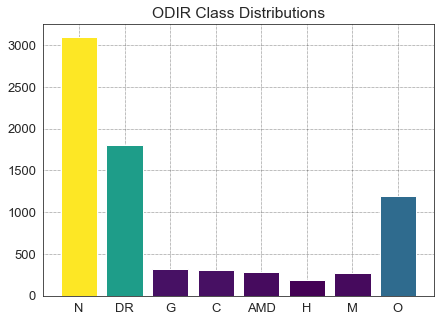

In [20]:
y = odir.iloc[:, 3:].sum(axis=0)
plt.bar(odir.columns[3:], y, color=viridis(rescale(y)))
plt.title('ODIR Class Distributions')

In [975]:
# Converting IDRiD and Messidor-2 to binary labels
idrid_dr = idrid['Retinopathy grade']
idrid_dr = np.where(idrid_dr > 0, 1, 0).reshape(-1, 1)
idrid['Retinopathy grade'] = idrid_dr
idrid['Image name'] += '.jpg'

# IDRiD test
idrid_test_dr = idrid_test['Retinopathy grade']
idrid_test_dr = np.where(idrid_test_dr > 0, 1, 0).reshape(-1, 1)
idrid_test['Retinopathy grade'] = idrid_test_dr
idrid_test['Image name'] = 'T' + idrid_test['Image name'] + '.jpg'

# Messidor-2
messidor_dr = messidor['adjudicated_dr_grade']
messidor_dr = np.where(messidor_dr > 0, 1, 0).reshape(-1, 1)
messidor['adjudicated_dr_grade'] = messidor_dr

In [976]:
# Formatting all the datasets and combining them into one
def format_binary(image_col, label_col, category, origin, dset_cols, df):
    # Getting image and label columns
    image_names = df[image_col] 
    image_names = image_names.rename('image_name')
    labels = df[label_col]
    dset_cat = {'DR': 1, 'G': 2, 'C': 3, 'AMD': 4, 'H': 5, 'M': 6, 'O': 7}

    # Creating array of one hot vectors for disease positive
    disease_pos = labels[labels == 1]
    disease_ind = disease_pos.index
    disease_labels = disease_pos.to_numpy()
    pos_one_hots = np.zeros((disease_labels.shape[0], 8), dtype=object)
    pos_one_hots[:, dset_cat[category]] = disease_pos

    # Creating array of one hot vectors for healthy
    healthy = labels[labels == 0]
    healthy_ind = healthy.index
    healthy_labels = np.ones(healthy.to_numpy().shape, dtype=int)
    neg_one_hots = np.zeros((healthy_labels.shape[0], 8), dtype=object)
    neg_one_hots[:, 0] = healthy_labels

    # Concatenating the images with the labels
    disease_pos = np.concatenate([image_names[disease_ind].to_numpy().reshape(-1, 1),
                    np.array([origin] * pos_one_hots.shape[0]).reshape(-1, 1),
                    pos_one_hots], axis=1)

    healthy = np.concatenate([image_names[healthy_ind].to_numpy().reshape(-1, 1),
                    np.array([origin] * neg_one_hots.shape[0]).reshape(-1, 1),
                    neg_one_hots], axis=1)

    df_formatted = pd.DataFrame(np.concatenate([disease_pos, healthy], axis=0), columns=dset_cols)
    return df_formatted

# We will use the same categories as ODIR for the dataset and also add an origin 
# column to better identify which datasets each image belongs to
dset = odir.drop(['ID', 'diagnosis'], axis=1)
dset.insert(1, 'origin', ['ODIR'] * odir.shape[0])

# Concatenating all the datasets with binary labels, only one that isn't is RFMiD
dset = dset.append(format_binary('imageID', 'binaryLabels', 'G', 'G1020', dset.columns, g1020))
dset = dset.append(format_binary('Image name', 'Retinopathy grade', 'DR', 'IDRiD', dset.columns, idrid))
dset = dset.append(format_binary('Image name', 'Retinopathy grade', 'DR', 'IDRiD', dset.columns, idrid_test))
dset = dset.append(format_binary('ImgName', 'glaucoma', 'G', 'REFUGE', dset.columns, refuge))
dset = dset.append(format_binary('ImgName', 'Glaucoma Label', 'G', 'REFUGE', dset.columns, refuge_valid))
dset = dset.append(format_binary('image_names', 'AMD', 'AMD', 'ADAM', dset.columns, adam))
dset = dset.append(format_binary('image_id', 'adjudicated_dr_grade', 'DR', 'MESSIDOR-2', dset.columns, messidor))
dset = dset.append(format_binary('image_names', 'myopia', 'M', 'PALM', dset.columns, palm))

# Formatting and appending RFMiD
rfmid_images = rfmid['ID'].astype('U') + '.png'
rfmid_images.rename('image_name')

# Diseased instances
rfmid_disease = rfmid[rfmid['Disease_Risk'] == 1]
rfmid_disease_ind = rfmid_disease.index
pos_one_hots = np.zeros((rfmid_disease.shape[0], 8), dtype=int)

# DR
rfmid_dr = rfmid_disease['DR'].astype(int)
pos_one_hots[:, 1] = rfmid_dr

# AMD
rfmid_amd = rfmid_disease['ARMD'].astype(int)
pos_one_hots[:, 4] = rfmid_amd

# Myopia
rfmid_myopia = rfmid_disease['MYA'].astype(int)
pos_one_hots[:, 6] = rfmid_myopia

# Other diseases
rfmid_other = (rfmid_disease.drop(['DR', 'ARMD', 'MYA'], axis=1).iloc[:, 2:].sum(axis=1) > 0).astype(int)
pos_one_hots[:, 7] = rfmid_other

# Healthy
rfmid_healthy = rfmid[rfmid['Disease_Risk'] == 0]
rfmid_healthy_ind = rfmid_healthy.index
neg_one_hots = np.zeros((rfmid_healthy.shape[0], 8), dtype=int)
neg_one_hots[:, 0] = np.ones(rfmid_healthy.shape[0], dtype=int)

# Concatenating the images with the labels
rfmid_disease = np.concatenate([rfmid_images[rfmid_disease_ind].to_numpy().reshape(-1, 1),
                np.array(['RFMiD'] * pos_one_hots.shape[0]).reshape(-1, 1),
                pos_one_hots], axis=1)

rfmid_healthy = np.concatenate([rfmid_images[rfmid_healthy_ind].to_numpy().reshape(-1, 1),
                np.array(['RFMiD'] * neg_one_hots.shape[0]).reshape(-1, 1),
                neg_one_hots], axis=1)

rfmid_formatted = pd.DataFrame(np.concatenate([rfmid_disease, rfmid_healthy], axis=0), columns=dset.columns)
dset = dset.append(rfmid_formatted)

# Resetting index
dset.index = range(dset.shape[0])
dset.tail()

,image_name,origin,N,DR,G,C,AMD,H,M,O
13770,1912.png,RFMiD,1,0,0,0,0,0,0,0
13771,1913.png,RFMiD,1,0,0,0,0,0,0,0
13772,1918.png,RFMiD,1,0,0,0,0,0,0,0
13773,1919.png,RFMiD,1,0,0,0,0,0,0,0
13774,1920.png,RFMiD,1,0,0,0,0,0,0,0


In [979]:
# Saving labels to dataset folder where all images are in the same directory
dset.to_csv(os.path.join(os.curdir, '../dataset/dataset.csv'), index=False)

In [978]:
# Checking if all images are present
DATASET_IMAGES = os.path.join(os.curdir, '../dataset/images/')
dataset_dirnames = set(os.listdir(DATASET_IMAGES))
dataset_image_names = set(dset['image_name'].tolist())
dataset_image_names.difference(dataset_dirnames)

set()

All images in our DataFrame are present in our dataset directory. We can get started on preprocessing the data and 
training the model.

### 3 Data Preprocessing and Pipelining

In [22]:
# For Colab
# DSET_IMAGES = os.path.join(os.curdir, '/content/My Drive/dataset/images/')
# DSET_LABELS = os.path.join(os.curdir, '/content/My Drive/dataset.csv')
DSET_IMAGES = os.path.join(os.curdir, '../dataset/images/')
DSET_LABELS = os.path.join(os.curdir, '../dataset/dataset.csv')
dset = pd.read_csv(DSET_LABELS).iloc[:, 1:]

In [23]:
dset = dset.sample(frac=1, random_state=42).reset_index(drop=True)
dset.tail()

,image_name,origin,N,DR,G,C,AMD,H,M,O
13770,3222_right.jpg,ODIR,1,0,0,0,0,0,0,0
13771,313.png,RFMiD,1,0,0,0,0,0,0,0
13772,3322_right.jpg,ODIR,1,0,0,0,0,0,0,0
13773,431_right.jpg,ODIR,0,1,0,0,0,0,0,0
13774,image_5.jpg,G1020,1,0,0,0,0,0,0,0


In [190]:
# Testing on IDRiD
X = (DSET_IMAGES + dset['image_name']).tolist()
y = dset.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=int(dset.shape[0]*0.1))

y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
y_test = tf.constant(y_test)

['./../dataset/images/986_right.jpg',
 './../dataset/images/TIDRiD_001.jpg',
 './../dataset/images/529_left.jpg',
 './../dataset/images/IM003856.JPG',
 './../dataset/images/4200_right.jpg',
 './../dataset/images/370.png',
 './../dataset/images/3435_left.jpg',
 './../dataset/images/3992_right.jpg',
 './../dataset/images/2343_left.jpg',
 './../dataset/images/2709_left.jpg',
 './../dataset/images/906_left.jpg',
 './../dataset/images/1396_left.jpg',
 './../dataset/images/20060529_57261_0100_PP.png',
 './../dataset/images/g0018.jpg',
 './../dataset/images/1073.png',
 './../dataset/images/image_745.jpg',
 './../dataset/images/IDRiD_137.jpg',
 './../dataset/images/2501_right.jpg',
 './../dataset/images/2990_right.jpg',
 './../dataset/images/REFUGEn0330.jpg',
 './../dataset/images/20051109_59969_0400_PP.png',
 './../dataset/images/image_1914.jpg',
 './../dataset/images/844_right.jpg',
 './../dataset/images/435_right.jpg',
 './../dataset/images/503_right.jpg',
 './../dataset/images/2590_left.jp

In [6]:
# Defining helper functions to convert to serializeable data types for TFRecord
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Create an example class for the TFRecord protobuf
def create_example(image_string, labels):
    feature = {
        'image_raw': _bytes_feature(image_string.numpy()),
        'labels': _bytes_feature(tf.io.serialize_tensor(labels).numpy()),
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto

def crop_image(img, tol=4):
    # tol  is tolerance, pixels to exclude from the mask
    img = np.asarray(img)
    mask = img > tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    img = img[row_start:row_end,col_start:col_end]
    img = tf.convert_to_tensor(img)
    return img

def create_record(path, X, y):
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    y = tf.convert_to_tensor(y)
    with tf.io.TFRecordWriter(path, options=options) as writer:
        for i in tqdm.trange(len(X)):
            try:
                image = tf.io.decode_image(tf.io.read_file(X[i]))
            except tf.errors.InvalidArgumentError as e:
                print(X[i])
                continue
            image = crop_image(image)
            image = tf.image.resize(image, (244, 244), method='nearest')
            image = tf.io.encode_jpeg(image)
            label = y[i]
            tf_example = create_example(image, label)
            writer.write(tf_example.SerializeToString())
            
dset_train = os.path.join(os.curdir, '../records244/dset_train.tfrecord')
dset_val = os.path.join(os.curdir, '../records244/dset_val.tfrecord')
dset_test = os.path.join(os.curdir, '../records244/dset_test.tfrecord')

#create_record(dset_train, X_train, y_train)
#create_record(dset_val, X_val, y_val)
#create_record(dset_test, X_test, y_test)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#train_shards = [os.path.join(dset_train, filename) for filename in os.listdir(dset_train)]

train_dataset = tf.data.TFRecordDataset(dset_train, compression_type='GZIP')
train_dataset = train_dataset.shuffle(2048)

val_dataset = tf.data.TFRecordDataset(dset_val, compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset(dset_test, compression_type='GZIP')

def _parse_dataset(example_proto, img_size=[244, 244]):
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    labels = tf.io.parse_tensor(parsed['labels'], tf.int64)
    labels.set_shape((8,))
    image = tf.io.decode_image(parsed['image_raw']) / 255
    image.set_shape(img_size + [3])
    image = tf.image.resize(image, img_size, method='nearest')
    return image, labels

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'labels': tf.io.FixedLenFeature([], tf.string)
}
train_dataset = train_dataset.map(_parse_dataset, num_parallel_calls=AUTOTUNE).batch(32)
val_dataset = val_dataset.map(_parse_dataset).batch(32)
test_dataset = test_dataset.map(_parse_dataset).batch(32)

In [11]:
normals = []
for batch in train_dataset:
    normals.append(batch[1])
    
normals = tf.concat(normals, 0)
tf.reduce_sum(normals, axis=0)


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([5266, 2583,  570,  245,  381,  159,  499, 1905])>

In [8]:
# Split a single TF Record into multiple files
def _parse_raw_dataset(example_proto, img_size=[360, 360]):
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    labels = tf.io.parse_tensor(parsed['labels'], tf.int64)
    labels.set_shape((8,))
    image = parsed['image_raw']
    return image, labels

def shard_tfrecord(path, name, record):
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    dset = tf.data.TFRecordDataset(record, compression_type='GZIP')
    dset = dset.map(_parse_raw_dataset).batch(1000)
    batch_id = 0
    for batch in dset:
        batch_ds = tf.data.Dataset.from_tensor_slices(batch)
        filename = f'{name}.{batch_id:03d}'
        record_path = os.path.join(path, filename)
        with tf.io.TFRecordWriter(record_path, options=options) as writer:
            for ex in batch_ds:
                tf_example = create_example(*ex)
                writer.write(tf_example.SerializeToString())
        batch_id += 1
        
def augment_image(image):
    image = tf.image.random_flip_left_right(image, seed=42)
    image = tf.image.random_flip_up_down(image, seed=42)
    image = tf.image.random_contrast(image, 0.8, 1.0, seed=42)
    image = tf.image.random_brightness(image, 0.1, seed=42)
    image = tf.minimum(image, 255)
    return image

def oversample_dataset(record, target):
    labels = []
    images = []
    
    augmented_images = []
    augmented_labels = []
    
    for batch in record:
        image = batch[0]
        label = batch[1]
        images.append(image)
        labels.append(label)
        
    images = tf.concat(images, 0)
    labels = tf.concat(labels, 0)
   
    for i in range(8):
        current = labels[:, i] == 1
        current_img = images[current]
        current_labels = labels[current]
        current_number = current_img.shape[0]
        
        # Number of images we need to create
        num_create = target - current_number
        
        if num_create < 0:
            augmented_images.extend(current_img)
            augmented_labels.extend(current_labels)
            continue
        
        ind = 0 
        for j in tqdm.trange(num_create):
            over_img = tf.io.decode_image(current_img[ind])
            over_lab = current_labels[ind]
            over_img = tf.io.encode_jpeg(augment_image(over_img))
            
            augmented_images.append(over_img)
            augmented_labels.append(over_lab)
            ind = min(ind, current_img.shape[0]-1)
            
        augmented_images.extend(current_img)
        augmented_labels.extend(current_labels)
            
    augmented_images = tf.stack(augmented_images)
    augmented_labels = tf.stack(augmented_labels)
    
    tf.random.set_seed(42)
    indices = tf.random.shuffle(tf.range(augmented_images.shape[0]), seed=42)
    augmented_images = tf.gather(augmented_images, indices)
    augmented_labels = tf.gather(augmented_labels, indices)
    
    return augmented_images, augmented_labels
        
def undersample(majority_images, majority_labels, target):
    tf.random.set_seed(42)
    indices = tf.random.shuffle(tf.range(majority_images.shape[0]), seed=42)[:target]
    under_sampled_img = tf.gather(majority_images, indices)
    under_sampled_labels = tf.gather(majority_labels, indices)
    return under_sampled_img, under_sampled_labels

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'labels': tf.io.FixedLenFeature([], tf.string)
}
        
train_dataset = tf.data.TFRecordDataset(dset_train, compression_type='GZIP').shuffle(2048).map(_parse_raw_dataset).batch(32)
#val_dataset = tf.data.TFRecordDataset(dset_val, compression_type='GZIP')
#test_dataset = tf.data.TFRecordDataset(dset_test, compression_type='GZIP')
#shard_tfrecord(shard_train, 'dset_train.tfrecord', dset_train)
images, labels = oversample_dataset(train_dataset, 1000)
#
#fig, axes = plt.subplots(4, 8)
#axes = axes.ravel()
#for ind, ax in enumerate(axes):
#    ax.imshow(augment_image(tf.io.decode_image(img[ind])))

100%|██████████| 501/501 [00:03<00:00, 135.00it/s]


In [12]:
def write_to_record(path, X, y):
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    with tf.io.TFRecordWriter(path, options=options) as writer:
        for i in tqdm.trange(X.shape[0]):
            tf_example = create_example(X[i], y[i])
            writer.write(tf_example.SerializeToString())
            
write_to_record('../records_over1000/dset_train.tfrecord', images, labels)

100%|██████████| 14754/14754 [00:16<00:00, 886.71it/s]


In [9]:
tf.reduce_sum(labels, axis=0)

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([5269, 3856, 1075, 1022, 1092, 1070, 1690, 2344])>

In [10]:
img = tf.io.decode_image(tf.io.read_file(os.path.join(DSET_IMAGES, 'IM004812.JPG')))
img = tf.image.central_crop(img, 0.75)

fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.tight_layout()
plt.subplots_adjust(top=0.4, wspace=0)
ind = 1
for row in axes:
    for ax in row:
        ax.grid('off')
        ax.axis('off')
        ax.set_title(f'{50 * ind}px')
        ax.imshow(tf.image.resize(img, [50 * ind, 50 * ind], method='nearest', preserve_aspect_ratio=True))
        ind += 1

NameError: name 'DSET_IMAGES' is not defined

In [79]:
# Preprocessing layers
class ImageResize(keras.layers.Layer):
    def __init__(self, shape=None, crop=None):
        super().__init__()
        self.shape = shape 
        self.crop = crop
        
    def call(self, inputs):
        if inputs.shape[1:-1] != self.shape:
            return inputs
        else:
            return tf.image.resize(inputs, self.shape)     
        return inputs

# Data augmentation 
class ImageAugmentation(keras.layers.Layer):
    def __init__(self, seed=None):
        super().__init__()
        self.seed = seed
        
    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.stateless_random_flip_left_right(inputs)
            inputs = tf.image.stateless_random_flip_up_down(inputs)
            inputs = tf.image.stateless_random_brightness(inputs, 0.2)
        return inputs

In [38]:
pos = tf.reduce_sum(y_train[:, 1])
neg = tf.reduce_sum(y_train[:, 0])
total = pos + neg
print(f'Class proportions: Positive: {pos/total}, Negative: {neg/total}')

Class proportions: Positive: 0.6759002770083102, Negative: 0.32409972299168976


Setting the proper bias (From Karpathy). Use this for imbalanced datasets like ours here.
\begin{equation}
    b_0 = \log_e(pos/neg)
\end{equation}

Predictions with this untrained model then would be:
\begin{equation}
    \hat{y} \; \text{~} \; pos/total
\end{equation}

In [55]:
# Setting the proper bias derived from above
bias = tf.initializers.Constant(np.log([pos/neg]))
bias

In [80]:
# Simple model for testing
model = keras.models.Sequential([
    ImageResize(shape=(50, 50), crop=0.75),
    #ImageAugmentation(),
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
    input_shape=[50, 50, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
optimizer = keras.optimizers.Nadam(lr=3e-4)
loss_fn = keras.losses.CategoricalCrossentropy()
metrics = [
    keras.metrics.CategoricalAccuracy(name='cat_acc'),
    keras.metrics.Precision(name='pr'),
    keras.metrics.Recall(name='rec'),
    keras.metrics.AUC(name='auc'),
]
model.compile(optimizer=optimizer, metrics=metrics, loss=loss_fn)

In [ ]:
history = model.fit(train_dataset, batch_size=32, epochs=20, validation_data=val_dataset)

Epoch 1/20


In [117]:
model.evaluate(test_dataset)

87/87 [==============================] - 16s 181ms/step - loss: 1.6424 - cat_acc: 0.4838 - pr: 0.6698 - rec: 0.0243 - auc: 0.8237


[1.6424180269241333,
 0.48384755849838257,
 0.6698113083839417,
 0.02430674433708191,
 0.8237107992172241]

In [41]:
# Custom training loop
#max_epoch = 5
#n_steps = len(X_train)
#optimizer = keras.optimizers.Nadam(lr=0.01)
#loss_fn = keras.losses.CategoricalCrossentropy
#mean_loss = keras.metrics.Mean()
#t = tqdm.trange(1, max_epoch+1)
#for epoch in t:
#    for batch in train_dataset:
#        print('peepee')
#        X_batch = decode_images(batch['image_raw'])
#        y_batch = decode_labels(batch['labels'])
#        with tf.GradientTape() as tape:
#            y_pred = model(X_batch, training=True)
#            print(y_pred)
#            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
#            loss = tf.add_n([main_loss] + model.losses)
#        gradients = tape.gradient(loss,model.trainable_variables)
#        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#        mean_loss(loss)
#        for metric in metrics:
#                metric(y_batch, y_pred)
#        t.set_description(f'Loss: {mean_loss.result}')
#    for metric in [mean_loss] + metrics:
#        metric.reset_states()